# **Setup**

In [ ]:
!nvidia-smi

Tue Jun 23 09:06:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa itlb_multihit
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits 

**CHECK FOR DECENT GPU** (not K80)

In [ ]:
# download and unpack tsnecuda from anaconda.org

!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.6/dist-packages/
!echo $LD_LIBRARY_PATH 
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so
import tsnecuda
# tsnecuda.test()

--2020-06-23 09:06:35--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-tar]
Saving to: ‘tsnecuda-2.1.0-cuda100.tar.bz2’

tsnecuda-2.1.0-cuda     [         <=>        ]  35.75M  7.86MB/s    in 5.4s    

2020-06-23 09:06:42 (6.60 MB/s) - ‘tsnecuda-2.1.0-cuda100.tar.bz2’ saved [37484309]

info/hash_input.json
info/index.json
info/files
info/git
info/about.json
info/recipe/docker/Dockerfile
info/recipe/docs/results/speedup.png
info/recipe/docs/results/multi-threaded.png
info/recipe/docs/cifar_speedup.png
info/recipe/docs/results/single-threaded.png
info/recipe/docs/mnist_speedup.png
info/recipe/docs/simulated_speedup.png
info/recipe/build/.gitkeep
info/recipe/conda_build_config.yaml
info/recipe/m

In [ ]:
import tsnecuda
# tsnecuda.test()
from tsnecuda import TSNE

**Install python packages**

In [ ]:
'''
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
'''
!pip install kmeans-pytorch

**Imports**

In [ ]:
import os
import logging
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms


from PIL import Image
from tqdm import tqdm

import copy
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import StratifiedShuffleSplit
import dill
import numpy as np


**Download dataset**

In [ ]:
# if not os.path.isdir('./cifar-100-python'):
#   !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
#   !tar xfz cifar-100-python.tar.gz

**MACROS**

In [ ]:
DEVICE = 'cuda'

NUM_EPOCHS = 70
BATCH_SIZE = 128
LR = 2.0
GAMMA = 0.2
K = 2000
FIRST_STEP = 49
SECOND_STEP = 63

**Load datasets**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([
                                      transforms.ToPILImage(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))                                    
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR100('./', train=True, transform=train_transform, target_transform=None, download=True)
test_dataset = torchvision.datasets.CIFAR100('./', train=False, transform=eval_transform, target_transform=None, download=False)

In [ ]:
print(train_dataset.class_to_idx)
print(train_dataset.classes)

{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'ray': 67, 'road': 68, 'rocket': 69, 'rose': 70, 

# **Split Dataset into batches of 10 classes**

In [ ]:
labels = train_dataset.classes.copy()
random.seed(666)
random.shuffle(labels)

# incremental_mapping = train_dataset.class_to_idx
# partitions = [labels]

incremental_mapping = {v: k for k, v in enumerate(labels)}
partitions = []
for i in range(10):
  partitions.append(labels[i*10:(i+1)*10])

In [ ]:
class BatchDataset:
  def __init__(self, dataset, labels, split='train', transform=None, target_transform=None, mapping = incremental_mapping):
    self.data_per_label=[]
    self.split = split
    self.transform = transform
    self.target_transform = target_transform
    self.data = []
    self.labels = labels
    self.labels_to_int = [incremental_mapping[label] for label in labels]
    
    for label in labels: 
      data_per_label=[(dataset.data[x], int(self.labels_to_int[labels.index(label)])) for x in [index for index, element in enumerate(dataset.targets) if element == dataset.class_to_idx[label]]]
      self.data+=data_per_label
      self.data_per_label.append(data_per_label)
  def __getitem__(self, index):
    image, label = self.data[index]
    if self.transform is not None:
      image = self.transform(image)
    return index, image, label

  def __len__(self):
    return len(self.data)

**Create splits**

In [ ]:
train_datasets = []
# val_datasets = []
test_datasets = []

for i, partition in enumerate(partitions):
  batch_test=BatchDataset(test_dataset,partition,transform=eval_transform, mapping = incremental_mapping)
  test_datasets.append(batch_test)
  batch = BatchDataset(train_dataset, partition,transform=train_transform, mapping = incremental_mapping)
  train_datasets.append(batch)
  # sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
  # for train_indexes, val_indexes in sss.split(range(len(batch)), [x[1] for x in batch.data]):
    # batch_val_dataset = Subset(batch, val_indexes)
    # batch_train_dataset = Subset(batch, train_indexes)
    # train_datasets.append(batch_train_dataset)
    # val_datasets.append(batch_val_dataset)
print(len(train_dataset))

50000


# **ResNet32**

**ResNets for CIFAR100**

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

"""
Credits to @hshustc
Taken from https://github.com/hshustc/CVPR19_Incremental_Learning/tree/master/cifar100-class-incremental
"""


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.out_dim = 64 * block.expansion

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model


# **iCaRL model**

ICARL NET 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from kmeans_pytorch import kmeans, kmeans_predict

class iCarlNet(nn.Module):

  def __init__(self, n_classes):
    self.total_num_classes = n_classes
    self.known_classes = 0
    self.list_known_classes=[]
    self.exemplar_sets = []
    self.flag_mean = True
    self.exemplar_means = []
    self.exemplars_list_knn=[]
    self.labels_knn=[]
    self.flag=True
    # We take a standard ResNet and Extend it
    super(iCarlNet, self).__init__()
    self.extractor = resnet32()
    self.fully_connected = nn.Linear(self.extractor.out_dim, 0, bias=True)
    #self.fully_connected=nn.Sequential(nn.Linear(self.extractor.out_dim,self.extractor.out_dim,bias=True),nn.ReLU(),nn.Linear(self.extractor.out_dim,self.extractor.out_dim,bias=True),nn.ReLU(),nn.Linear(self.extractor.out_dim,0))
    #self.fully_connected=nn.Sequential(nn.Linear(self.extractor.out_dim,self.extractor.out_dim,bias=True),nn.ReLU(),nn.Linear(self.extractor.out_dim,42,bias=True),nn.ReLU(),nn.Linear(42,0))
    torch.nn.init.xavier_uniform_(self.fully_connected.weight)
    self.fully_connected.bias.data.fill_(0.01)
    self.loss=nn.BCEWithLogitsLoss()
        
  def forward(self, x):
    # X: input data

    self.extractor.to(DEVICE)
    self.fully_connected.to(DEVICE)

    x = self.extractor(x)
    x = self.fully_connected(x)

    return x

  def batch_forward(self,x):
    self.step_extractor.to(DEVICE)
    self.step_fully_connected.to(DEVICE)
    x = self.step_extractor(x)
    x = self.step_fully_connected(x)
    return x

  def batch_trainer(self,dataset):
    self.train()
    self.step_fully_connected = nn.Linear(self.extractor.out_dim, 10, bias=True)
    torch.nn.init.xavier_uniform_(self.step_fully_connected.weight)
    self.step_fully_connected.bias.data.fill_(0.01)
    self.step_extractor = resnet32()
    classes_to_idx = dataset.labels_to_int
    offset = min(classes_to_idx)
    train_data_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
    scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)

    N_CLASSES = 10
    eye = torch.eye(N_CLASSES)
    for epoch in range(NUM_EPOCHS):
      print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
      i=0
      for indices, images, labels in train_data_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        indices = indices.to(DEVICE)
        optimizer.zero_grad()
        labels_one_hot_new_classes = []
        for label in labels:
          labels_one_hot_new_classes.append(eye[label-offset])
        labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
        output = self.batch_forward(images)
        loss=self.loss(output,labels_one_hot_new_classes)
        loss.backward()
        optimizer.step()
        i+=1
      print(f"Loss step extractor: {loss.item()}")
      torch.cuda.empty_cache()
      scheduler.step() 
  
  def classify_without_mean_cosine_similarity(self,input_image_batch):
    # input image batch: batch of 128 images to compute predictions on

    self.eval()
    with torch.no_grad():
      # mean: tensor of dimension: known_classes x features (64)
      mean = torch.stack(self.exemplar_means).squeeze(1).cuda()
      # extract the features of the whole batch 
      self.extractor.to(DEVICE)   
      features = self.extractor(input_image_batch)        
      predictions = []

      # normalize and predict by nearest exemplar mean
      for n, feature in enumerate(features):
        feature.data = feature.data / feature.data.norm() 
        feature=feature.expand_as(mean)
        cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-08)
        distances=cosine_similarity(feature,mean)
        predictions.append(torch.argmax(distances, 0))
      return predictions

  def compute_exemplar_list_knn(self,transform):
    self.eval()
    with torch.no_grad():
      exemplar_features = []
      labels=[]
      for i,exemplars in enumerate(self.exemplar_sets):
        for exemplar in exemplars:
          feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
          feature.data = feature.data / feature.data.norm()
          exemplar_features.append(feature)
          labels.append(i)
      
      self.exemplars_list_knn=exemplar_features
      self.labels_knn=labels

  def KNN_classify(self,input_image_batch,k):
    exemplar_features=torch.stack(self.exemplars_list_knn).squeeze(1)
    self.eval()
    with torch.no_grad():
      # mean: tensor of dimension: known_classes x features (64)
      # mean = torch.stack(self.exemplar_means).squeeze(1).cuda()
      # extract the features of the whole batch 
      self.extractor.to(DEVICE)   
      features = self.extractor(input_image_batch)        
      predictions = []

      # normalize and predict by nearest exemplar mean
      for n, feature in enumerate(features):
        labels_knn=[]
        feature.data = feature.data / feature.data.norm() 
        feature=feature.expand_as(exemplar_features)
        l2_distances=torch.sum((feature - exemplar_features)**2, 1)
        knn=l2_distances.topk(k, largest=False)
        for index in knn.indices.tolist():
          labels_knn.append(self.labels_knn[index])
        predictions.append(torch.tensor(max(set(labels_knn),key=labels_knn.count)))
      return predictions

  def update_representation_using_cross_entropy_and_kl(self, dataset):
    # dataset: training data belonging to 10 new classes

    ########################################
    #loss1=nn.MSELoss()
    loss1=nn.CrossEntropyLoss(ignore_index=-1)
    loss2=nn.MSELoss()
    #loss2=nn.KLDivLoss(reduction='batchmean')
    #loss2=nn.CrossEntropyLoss()
    sigmoid = nn.Sigmoid()
    log_sigmoid = nn.LogSigmoid()
    softmax = nn.Softmax()
    log_softmax = nn.LogSoftmax()
    optimizer = optim.SGD(self.parameters(), lr=0.2,weight_decay=0.00001, momentum = 0.9)
    scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
    ########################################

    self.combine_dataset_with_exemplars(dataset)
    self.flag_mean = True
    classes_to_idx = dataset.labels_to_int
    new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes]

    train_data_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    # if some classes have been previously observed, compute the
    # outputs of the new data on the old weights

    if self.known_classes > 0:
      self.eval()
      logits_old_net = torch.zeros(len(dataset.data), self.known_classes).cuda()
      labels_old_net = torch.zeros(len(dataset.data)).cuda()

      with torch.no_grad():
        for indices, images, labels in train_data_loader:
          images = images.to(DEVICE)
          g = self.forward(images)
          logits_old_net[indices] = sigmoid(g)
          #logits_old_net[indices]=softmax(g)
          _,predictions=torch.max(g.data,1)
          labels_old_net[indices]=predictions.type(torch.cuda.FloatTensor)

      torch.cuda.empty_cache()

    self.increment_classes(new_classes)
    
    # start training on the new batch of 10 classes + exemplars
    self.train()
    for epoch in range(NUM_EPOCHS):
      print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
      i=0
      for indices, images, labels in train_data_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        indices = indices.to(DEVICE)
        optimizer.zero_grad()
        output = self.forward(images)

        # classification loss only for the first batch of 10 classes
        if self.known_classes==0:
          #labels_one_hot_new_classes = []
          #for label in labels:
          #  labels_one_hot_new_classes.append(eye[label])
          #labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
          #loss=self.loss(output,labels_one_hot_new_classes)
          #loss=loss1(softmax(output),torch.eye(self.known_classes+10)[labels].cuda()) mse calssification
          loss=loss1(output,labels) #croos_entropy classification
          loss.backward()
        # clf + dst loss
        if self.known_classes > 0:
          #labels_one_hot_new_classes = eye[:, self.known_classes:]
          # print(labels_one_hot_new_classes.size())
          #labels_one_hot = []
          #for label in labels:
          #  labels_one_hot.append(labels_one_hot_new_classes[label])
          #labels_one_hot = torch.stack(labels_one_hot).cuda()
          logits = logits_old_net[indices].cuda()
          labels_distillation=labels_old_net[indices].cuda()
          # print(f"logits old net: {logits.size()}")
          # print(f"new classes onehot encoded: {labels_one_hot.size()}")
          #labels_concatenate = torch.zeros(logits_old_net.size()
          # print(f"{logits.size()}-{labels_one_hot.size()}")
          #labels_concatenate=torch.cat((logits,labels_one_hot),dim=1)
          #loss_classification=loss1(softmax(output),torch.eye(self.known_classes+10)[labels].cuda()) #mse classification
          loss_classification=loss1(output,labels) #cross_entropy classification
          #print("loss_classification :{}".format(loss_classification.item()))
          #loss_distillation=loss2((output[:,:self.known_classes]),labels_distillation.type(torch.cuda.LongTensor)) #cross_entropy_distillation
          loss_distillation=loss2(sigmoid(output[:,:self.known_classes]),logits)
          #print("loss_distillation :{}".format(loss_distillation.item()))
          loss=loss_classification+abs(loss_distillation)
          loss.backward()
        optimizer.step()
        i+=1
      torch.cuda.empty_cache()
      print(f"Loss: {loss.item()}")
      scheduler.step() 
    self.known_classes += len(new_classes)

  def update_representation(self, dataset):             
    self.combine_dataset_with_exemplars(dataset)
    self.flag_mean = True
    classes_to_idx = dataset.labels_to_int
    new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes] #gets indexes of new classes only

    train_data_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    preds_old_net = []
    #preds_old_net = torch.zeros(len(dataset), self.num_classes).cuda()
    
    if self.known_classes > 0:
      print(f"calculating output old classes")
      self.eval()
      logits_old_net = torch.zeros(len(dataset.data), self.known_classes).cuda()
      with torch.no_grad():
        for indices, images, labels in train_data_loader:
          images = images.to(DEVICE)
          g = self.forward(images)
          sigmoid = torch.nn.Sigmoid()
          logits_old_net[indices] = sigmoid(g)
        # preds_old_net.append(g.data)
        # preds_old_net[indices] = g.data
      
      # print(f"Labels old net size: {preds_old_net.size()}")
      # print(f"Labels old net: {preds_old_net}")
      # preds_old_net = preds_old_net.to(DEVICE)
      # logits_old_net = torch.cat(logits_old_net)         
      # print(logits_old_net.size())
      torch.cuda.empty_cache()

    self.increment_classes(new_classes)
    
    optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
    scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
    self.train()

    eye = torch.eye(self.known_classes+len(new_classes))

    for epoch in range(NUM_EPOCHS):
      print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
      i=0
      for indices, images, labels in train_data_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        indices = indices.to(DEVICE)
        optimizer.zero_grad()
        output = self.forward(images)
        # print(f"Output size: {output.size()}")
        # print(f"Labels size: {labels.size()}")

        if self.known_classes==0:
          labels_one_hot_new_classes = []
          for label in labels:
            labels_one_hot_new_classes.append(eye[label])
          labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
          loss=self.loss(output,labels_one_hot_new_classes)
          loss.backward()
        if self.known_classes > 0:
          labels_one_hot_new_classes = eye[:, self.known_classes:]
          # print(labels_one_hot_new_classes.size())
          labels_one_hot = []
          for label in labels:
            labels_one_hot.append(labels_one_hot_new_classes[label])
          labels_one_hot = torch.stack(labels_one_hot).cuda()
          logits = logits_old_net[indices].cuda()
          # print(f"logits old net: {logits.size()}")
          # print(f"new classes onehot encoded: {labels_one_hot.size()}")
          #labels_concatenate = torch.zeros(logits_old_net.size()
          # print(f"{logits.size()}-{labels_one_hot.size()}")
          labels_concatenate=torch.cat((logits,labels_one_hot),dim=1)
          loss=self.loss(output,labels_concatenate)
          loss.backward()
        optimizer.step()
        i+=1
      torch.cuda.empty_cache()
      print(f"Loss: {loss.item()}")
      scheduler.step() 
    self.known_classes += len(new_classes)

  def classify(self, input_image_batch, transform):
    # input_image_batch: batch of up to 10 shuffled classes that we use for training and validation
    # transform: transformation to be applied to raw exemplar images
    batch_size = input_image_batch.size(0)
    self.eval()
    with torch.no_grad():
      if self.flag_mean:
        print(f"num exemplar sets: {len(self.exemplar_sets)}")
        exemplar_means = []
        for exemplars in self.exemplar_sets:
          features = []
          for exemplar in exemplars:
            feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
            feature.data = feature.data / feature.data.norm()
            features.append(feature)
          features = torch.stack(features)
          exemplar_mean = torch.mean(features, 0)
          exemplar_means.append(exemplar_mean)
        print(f"Exemplar means len: {len(exemplar_means)}")
        self.exemplar_means = exemplar_means
        self.flag_mean = False

      mean = torch.stack(self.exemplar_means).squeeze(1)    # tensor of dimension: known_classes x features (64)
      # print(mean.size())
      features = self.extractor(input_image_batch)          # extracts the features of the batch
      predictions = []
      for n, feature in enumerate(features):
        feature.data = feature.data / feature.data.norm()   # normalize and returns the distance of the nearest one
      # Predict label by nearest exemplar mean
        distances = torch.sum((feature - mean)**2, 1)
        predictions.append(torch.argmin(distances, 0))
      return predictions

  def classify_without_mean(self,input_image_batch):
    # input_image_batch: batch of up to 10 shuffled classes that we use for training and validation

    self.eval()
    with torch.no_grad():
      # mean: tensor of dimensions known_classes x features (64)
      mean = torch.stack(self.exemplar_means).squeeze(1)    

      features = self.extractor(input_image_batch)          # extracts the features of the batch
      predictions = []
      for n, feature in enumerate(features):
        feature.data = feature.data / feature.data.norm()   # normalize and returns the distance of the nearest one
        # Predict label by nearest exemplar mean
        distances = torch.sum((feature - mean)**2, 1)
        predictions.append(torch.argmin(distances, 0))
      return predictions

  def construct_with_class_mean(self, images, exemplars_per_class, transform):
    self.eval()
    with torch.no_grad():
      if self.flag_mean:
        print(f"num exemplar sets: {len(self.exemplar_sets)}")
        exemplar_means = []
        for exemplars in self.exemplar_sets:
          features = []
          for exemplar in exemplars:
            feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
            feature.data = feature.data / feature.data.norm()
            features.append(feature)
          features = torch.stack(features)
          exemplar_mean = torch.mean(features, 0)
          exemplar_means.append(exemplar_mean)
        print(f"Exemplar means len: {len(exemplar_means)}")
        self.exemplar_means = exemplar_means
        self.flag_mean = False
  
      images_features = []
      exemplar_set = []
      exemplar_features = []
      for image in images:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = self.extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features.append(feature)
      images_features = torch.stack(images_features, dim=0)
      # should do the mean on the dimension of the append
      class_mean = torch.mean(images_features, 0)
      class_mean = class_mean / class_mean.norm()
      # self.exemplar_means.append(class_mean)
      for i in range(exemplars_per_class):                #gets the nearest image to the mean and returns it
        mask = [True]*len(images)
        total = np.sum(exemplar_features, axis=0)
        extracted_features = images_features
        mean = class_mean
        average_feature_vector = (float(1)/(i+1))*(extracted_features + total).squeeze(1)
        average_feature_vector = average_feature_vector / average_feature_vector.norm()
        j = torch.argmin(torch.sqrt(
            torch.sum(mean-average_feature_vector, 1)**2))
        exemplar_set.append(images[j][0])
        exemplar_features.append(extracted_features[j].squeeze(0))
        mask[j] = False
        images_features = images_features[mask]
        images = np.array(images)[mask].tolist()
      self.exemplar_sets.append(exemplar_set)
      print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  def construct_exemplar_set(self, images, exemplars_per_class, transform):     # images: images of one class of the training set, exemplars_per_class is m, transform is the transformation
    self.eval()
    with torch.no_grad():
      images_features = []
      exemplar_set = []
      exemplar_features = []
      for image in images:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = self.extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features.append(feature)
      images_features = torch.stack(images_features, dim=0)
      # should do the mean on the dimension of the append
      class_mean = torch.mean(images_features, 0)
      class_mean = class_mean / class_mean.norm()         #computes the mean of the class and normalizes it, it creates the features of the average image
      self.exemplar_means.append(class_mean)
      for i in range(exemplars_per_class):                #gets the nearest image to the mean and returns it
        mask = [True]*len(images)
        total = np.sum(exemplar_features, axis=0)
        extracted_features = images_features
        mean = class_mean
        average_feature_vector = (float(1)/(i+1))*(extracted_features + total).squeeze(1)
        average_feature_vector = average_feature_vector / average_feature_vector.norm()
        j = torch.argmin(torch.sqrt(
            torch.sum(mean-average_feature_vector, 1)**2))
        exemplar_set.append(images[j][0])
        exemplar_features.append(extracted_features[j].squeeze(0))
        mask[j] = False
        images_features = images_features[mask]
        images = np.array(images)[mask].tolist()
      self.exemplar_sets.append(exemplar_set)
      print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  def construct_exemplar_set_mean_images(self, images_per_label, num_exemplars, num_clusters, num_images_per_cluster, transform):
    self.eval()
    with torch.no_grad():
      images_features = []
      for image in images_per_label:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = self.extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features.append(feature)
      images_features = torch.stack(images_features, dim=0)
      # should do the mean on the dimension of the append
      class_mean = torch.mean(images_features, 0)
      class_mean = class_mean / class_mean.norm()
      self.exemplar_means.append(class_mean)

      device = torch.device('cuda:0')
      # images_features = []
      # self.extractor.to(DEVICE)
      # for image in images_per_label:
      #   image_features = self.extractor(transform(image[0]).unsqueeze(0).cuda())
      #   image_features.data = image_features.data / image_features.data.norm()
      #   images_features.append(image_features)
      # # images_features: list of tensors 1x64
      # images_features = torch.stack(images_features).squeeze(1)
      # print(f"Stacked images features: {images_features.size()}")
      # reduced_features = TSNE(n_components=2 , perplexity=15 , learning_rate=10).fit_transform(images_features.cpu())
      # print(f"reduced features size: {torch.tensor(reduced_features).size()}")
      # reduced_features= torch.tensor(reduced_features).cuda()
      # clusters_indices_x size: len(images_per_label) x 1
      # cluster_centers size: num_cluster x 2
      clusters_indices_x, cluster_centers = kmeans(images_features.squeeze(1), num_clusters = num_clusters, distance = 'euclidean', device = device)

      # class mean for NME classify, class_mean_classify size: 1x64
      # class_mean_classify = torch.mean(images_features.unsqueeze(1), 0)
      # print(f"class mean size: {class_mean_classify.size()}")
      # class_mean_classify = class_mean_classify / class_mean_classify.norm()
      # self.exemplar_means.append(class_mean_classify.cuda())

      # class mean for clustering, class_mean size: 1x2 
      # class_mean = torch.mean(images_features)
      # class_mean.data = class_mean.data / class_mean.data.norm()

      # centroid_distances size: num_clusters x 1
      print(cluster_centers.size())
      print(class_mean.size())
      
      centroid_distances = torch.sum((cluster_centers.cuda() - class_mean.cuda())**2, dim=1)
      centroid_distances = centroid_distances / torch.sum(centroid_distances)
      print(f"Distances size: {centroid_distances.size()}")

      # fill clusters
      clusters = []
      for i in range(num_clusters):
        cluster = [j for j, x in enumerate(clusters_indices_x) if x == i]
        clusters.append(cluster)

      images_mean = []
      pil = transforms.ToPILImage()
      for m in range(num_exemplars):
        image_mean = np.zeros((32, 32, 3))
        for i, cluster in enumerate(clusters): 
          # indices of cluster images to be used for image_mean
          cluster_images = random.choices(cluster, k = min(len(cluster), num_images_per_cluster-1) )
          for j in  cluster_images:
            image = images_per_label[j][0]
            image_mean += (1 - centroid_distances[i].item())*image
        image_mean /= np.max(image_mean)
        image_mean *= 255
        image_mean = image_mean.astype(np.uint8)
        # plt.imshow(pil(image_mean))
        # plt.show()
        images_mean.append(image_mean)
      print("Matteo merda")
      self.exemplar_sets.append(images_mean)

  def construct_exemplar_set_mean_images_no_clusters(self, images_per_label, num_exemplars, num_images_per_exemplar, transform):
    self.eval()
    with torch.no_grad():
      images_features = []
      for image in images_per_label:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = self.extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features.append(feature)
      images_features = torch.stack(images_features, dim=0)
      # should do the mean on the dimension of the append
      class_mean = torch.mean(images_features, 0)
      class_mean = class_mean / class_mean.norm()
      self.exemplar_means.append(class_mean)
      class_mean = class_mean.squeeze(1)
      images_features = images_features.squeeze(1)
      distances = torch.sum((class_mean - images_features)**2, 1)
      distances /= torch.sum(distances)

      pil = transforms.ToPILImage()
      images_mean = []

      for i in range(num_exemplars):                #gets the nearest image to the mean and returns it
        j = random.choices(range(len(images_per_label)), k = num_images_per_exemplar)
        image_mean = np.zeros((32,32,3))
        image_mean += 0.8*images_per_label[j[0]][0]
        for image in j[1:]:
          image_mean += 0.2/(num_images_per_exemplar-1)*images_per_label[image][0]

        if np.max(image_mean) > 255:
          image_mean /= np.max(image_mean)
          image_mean *= 255
        image_mean = image_mean.astype(np.uint8)

        images_per_label = [x for n, x in enumerate(images_per_label) if n != j[0]]
        images_mean.append(image_mean)
        # plt.imshow(pil(image_mean))
        # plt.show()
      self.exemplar_sets.append(images_mean)
      print("Matteo merda")
      print(f"Created exemplar set for class {images_per_label[0][1]} of len {len(self.exemplar_sets[0])}")

  def construct_examplar_set_mean_image_with_clusters(self, images_per_label, num_exemplars, num_clusters, num_images_per_cluster, transform, feature_extractor):
    self.eval()
    with torch.no_grad():
  
      images_features = []
      exemplar_set = []
      exemplar_features = []
      for image in images_per_label:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = self.extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features.append(feature)
      images_features = torch.stack(images_features, dim=0)
      # should do the mean on the dimension of the append
      class_mean = torch.mean(images_features, 0)
      class_mean = class_mean / class_mean.norm()
      self.exemplar_means.append(class_mean)

      images_features_step_extractor = []
      for image in images_per_label:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = feature_extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features_step_extractor.append(feature)
      images_features_step_extractor = torch.stack(images_features_step_extractor, dim=0)
      # should do the mean on the dimension of the append

      device = torch.device('cuda:0')
      clusters_indices_x, cluster_centers = kmeans(images_features_step_extractor.squeeze(1), num_clusters = num_clusters, distance = 'euclidean', device = device)
      print(cluster_centers.size())
      print(class_mean.size())
      
      centroid_distances = torch.sum((cluster_centers.cuda() - class_mean.cuda())**2, dim=1)
      centroid_distances = centroid_distances / torch.sum(centroid_distances)
      print(f"Distances size: {centroid_distances.size()}")

      # fill clusters
      clusters = []
      cluster_distances=[]
      for i in range(num_clusters):
        cluster = [j for j, x in enumerate(clusters_indices_x) if x == i]
        clusters.append(cluster)
        distances_from_centroid=[]
        for image_index in cluster:
          distances_from_centroid.append((torch.sum((images_features_step_extractor[image_index][0].cuda()-cluster_centers[i].cuda())**2).cuda()))
           
        cluster_distances.append(distances_from_centroid)
      images_mean = []
      pil = transforms.ToPILImage()
      images_mean = []
      pil = transforms.ToPILImage()
      for m in range(num_exemplars):
        image_mean = np.zeros((32, 32, 3))
        i=random.randint(0,len(clusters)-1)
        while(len(cluster_distances[i])==0):
          i=random.randint(0,len(clusters)-1)
        index_nearest=np.argmin(cluster_distances[i])
        #print(index_nearest)
        #print(type(index_nearest))
        if(type(index_nearest) is not np.int64):
          index_nearest=index_nearest[0]
        index_nearest_image=clusters[i][index_nearest]
        cluster_distances[i]=[x for n,x in enumerate(cluster_distances[i]) if n!=index_nearest]
        clusters[i]=[x for n,x in enumerate(clusters[i]) if n!=index_nearest]
          # indices of cluster images to be used for image_mean
        cluster_images = random.choices(cluster, k = min(len(cluster), num_images_per_cluster-1) )
        image_mean+=0.8*images_per_label[index_nearest_image][0]
        for j in  cluster_images:
          image = images_per_label[j][0]
          image_mean += 0.2/len(cluster_images)*image
        if(np.max(image_mean)>255):
          image_mean /= np.max(image_mean)
          image_mean *= 255
        image_mean = image_mean.astype(np.uint8)
        # pil=transforms.ToPILImage()
        # if(m%20==0):
        #   plt.imshow(pil(image_mean))
        #   plt.show()
        images_mean.append(image_mean)
      print("Matteo merda")
      self.exemplar_sets.append(images_mean)

  def construct_examplar_set_random(self, images, exemplars_per_class, transform):
    self.eval()
    with torch.no_grad():
  
      images_features = []
      exemplar_set = []
      exemplar_features = []
      for image in images:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = self.extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features.append(feature)
      images_features = torch.stack(images_features, dim=0)
      # should do the mean on the dimension of the append
      class_mean = torch.mean(images_features, 0)
      class_mean = class_mean / class_mean.norm()
      self.exemplar_means.append(class_mean)
      for i in range(exemplars_per_class):                #gets the nearest image to the mean and returns it
        mask = [True]*len(images)
        j = random.choice(range(len(images)))
        exemplar_set.append(images[j][0])
        mask[j] = False
        images_features = images_features[mask]
        images = np.array(images)[mask].tolist()
      self.exemplar_sets.append(exemplar_set)
      print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  def compute_means(self,transform):
    self.eval()
    with torch.no_grad():
      print(f"num exemplar sets: {len(self.exemplar_sets)}")
      exemplar_means = []
      for exemplars in self.exemplar_sets:
        features = []
        for exemplar in exemplars:
          feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
          feature.data = feature.data / feature.data.norm()
          features.append(feature)
        features = torch.stack(features)
        exemplar_mean = torch.mean(features, 0)
        exemplar_means.append(exemplar_mean)
      print(f"Exemplar means len: {len(exemplar_means)}")
      self.exemplar_means = exemplar_means
      self.flag_mean = False

  def combine_dataset_with_exemplars(self, dataset):    #combines them
    list_exemplars = []
    for label, exemplars in enumerate(self.exemplar_sets):
      list_exemplars += [(image, label) for image in exemplars]
      dataset.labels_to_int.append(label)
    dataset.data = list_exemplars + dataset.data

  def increment_classes(self, classes_to_add):          # increments the number of classes we are using
    n_classes_to_add = len(classes_to_add)
    self.list_known_classes+=classes_to_add             #add the new classes
    print(f"Known classes {self.list_known_classes}")
    #weight = self.fully_connected[4].weight.data
    weight = self.fully_connected.weight.data
    #feature_size = self.fully_connected[4].in_features
    feature_size = self.fully_connected.in_features
    #old_num_classes = self.fully_connected[4].out_features
    old_num_classes = self.fully_connected.out_features
    #self.fully_connected[4] = nn.Linear(
    #    feature_size, old_num_classes+n_classes_to_add, bias = True)
    #self.fully_connected[4].weight.data[:old_num_classes] = weight
    self.fully_connected = nn.Linear(
        feature_size, old_num_classes+n_classes_to_add, bias = True)
    self.fully_connected.weight.data[:old_num_classes] = weight

  def reduce_exemplar_sets(self, m):                    # reduces exemplar set
    for i in range(len(self.exemplar_sets)):
      self.exemplar_sets[i] = self.exemplar_sets[i][:m]
      print(f"Reducing exemplars of class {i} to {len(self.exemplar_sets[i])}")

  def classifierMlp(self,images):
    self.eval()
    self.fully_connected.to(DEVICE)
    self.extractor.to(DEVICE)
    outputs=self.fully_connected(self.extractor(images))
    _,preds=torch.max(outputs.data,1)
    return preds


**Training with mean images**

In [ ]:
class featureExtractor(nn.Module):
  def __init__(self):
    super(featureExtractor, self).__init__()
    self.extractor = resnet32()
    self.fully_connected = nn.Linear(self.extractor.out_dim, 10, bias=True)
    torch.nn.init.xavier_uniform_(self.fully_connected.weight)
    self.fully_connected.bias.data.fill_(0.01)
    self.loss=nn.BCEWithLogitsLoss()

  def forward(self, x):
    self.extractor.to(DEVICE)
    self.fully_connected.to(DEVICE)

    x = self.extractor(x)
    x = self.fully_connected(x)
    
    return x

  def train(self, dataset):
    classes_to_idx = dataset.labels_to_int
    offset = min(classes_to_idx)
    train_data_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
    scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)

    N_CLASSES = 10
    eye = torch.eye(N_CLASSES)
    for epoch in range(NUM_EPOCHS):
      print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
      i=0
      for indices, images, labels in train_data_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        indices = indices.to(DEVICE)
        optimizer.zero_grad()
        labels_one_hot_new_classes = []
        for label in labels:
          labels_one_hot_new_classes.append(eye[label-offset])
        labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
        output = self.forward(images)
        loss=self.loss(output,labels_one_hot_new_classes)
        loss.backward()
        optimizer.step()
        i+=1
      print(f"Loss step extractor: {loss.item()}")
      torch.cuda.empty_cache()
      scheduler.step() 

net=iCarlNet(n_classes=100)
net.to(DEVICE)
accuracies = []
for i, train_dataset in enumerate(train_datasets):
  torch.cuda.empty_cache()
  print(f"BATCH [{i}]")
  print(f"Training on {train_dataset.labels} -> {train_dataset.labels_to_int}")
  net.train()
  # net.batch_trainer(copy.deepcopy(train_dataset))
  # extractor = featureExtractor()
  # extractor.train(copy.deepcopy(train_dataset))
  net.update_representation(copy.deepcopy(train_dataset))
  # net.update_representation_using_cross_entropy_and_kl(copy.deepcopy(train_dataset))

  m = int(K/((i+1)*10))
  net.compute_means(train_dataset.transform)
  net.reduce_exemplar_sets(m)
  for data_per_label in train_dataset.data_per_label:
    print(f"Constructing exemplar for class [{data_per_label[0][1]}]")
    #net.construct_exemplar_set(data_per_label,m,train_dataset.transform)
    #net.construct_exemplar_set_with_class_mean(data_per_label,m,train_dataset.transform)
    # net.construct_exemplar_set_mean_images(data_per_label, m , 5, 8, train_dataset.transform)
    # net.construct_exemplar_set_mean_images_no_clusters(data_per_label, m , 6, train_dataset.transform)
    net.construct_examplar_set_mean_image_with_clusters(data_per_label, m , 10, 30, train_dataset.transform, copy.deepcopy(net.extractor))
    #net.construct_exemplar_set_with_centroids(data_per_label,m,train_dataset.transform)
    # net.construct_examplar_set_random(data_per_label,m,train_dataset.transform)
  
  #net.compute_exemplar_list_knn(train_dataset.transform)
  net.eval()
  corrects = 0
  total = 0
  
  with torch.no_grad():
    for num in range(i+1):
      print(f"Validating classes {test_datasets[num].labels} -> {test_datasets[num].labels_to_int}")
      test_dataloader = DataLoader(test_datasets[num], batch_size=BATCH_SIZE, num_workers=4, shuffle = True)
      for _, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # classify using NME
        #preds = torch.stack(net.KNN_classify(images,35)).cuda()
        #preds=torch.stack(net.classify_without_mean_cosine_similarity(images)).cuda()
        preds = torch.stack(net.classify_without_mean(images)).cuda()
        #preds=net.classifierMlp(images)
        # Update Corrects
        #outputs = net(images)
        #_, preds = torch.max(outputs.data, 1)
        corrects += torch.sum(preds == labels.data).data.item()
        total += len(images)
    torch.cuda.empty_cache()
    # Calculate Accuracy
    accuracy = corrects / float(total)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy}")

BATCH [0]
Training on ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Epoch [1/70], LR: [2.0]
Loss: 0.31328269839286804
Epoch [2/70], LR: [2.0]
Loss: 0.33147579431533813
Epoch [3/70], LR: [2.0]
Loss: 0.31944331526756287
Epoch [4/70], LR: [2.0]
Loss: 0.30695781111717224
Epoch [5/70], LR: [2.0]
Loss: 0.33906397223472595
Epoch [6/70], LR: [2.0]
Loss: 0.29149118065834045
Epoch [7/70], LR: [2.0]
Loss: 0.29746589064598083
Epoch [8/70], LR: [2.0]
Loss: 0.2880215048789978
Epoch [9/70], LR: [2.0]
Loss: 0.34880611300468445
Epoch [10/70], LR: [2.0]
Loss: 0.3041495382785797
Epoch [11/70], LR: [2.0]
Loss: 0.2621713876724243
Epoch [12/70], LR: [2.0]
Loss: 0.31541168689727783
Epoch [13/70], LR: [2.0]
Loss: 0.2630032002925873
Epoch [14/70], LR: [2.0]
Loss: 0.29647096991539
Epoch [15/70], LR: [2.0]
Loss: 0.3561781346797943
Epoch [16/70], LR: [2.0]
Loss: 0.323196530342

[running kmeans]: 29it [00:00, 267.09it/s, center_shift=0.000048, iteration=29, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [1]


[running kmeans]: 10it [00:00, 275.44it/s, center_shift=0.000008, iteration=10, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [2]


[running kmeans]: 22it [00:00, 281.80it/s, center_shift=0.000000, iteration=22, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [3]


[running kmeans]: 14it [00:00, 264.54it/s, center_shift=0.000091, iteration=14, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [4]


[running kmeans]: 20it [00:00, 269.86it/s, center_shift=0.000072, iteration=20, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [5]


[running kmeans]: 12it [00:00, 269.43it/s, center_shift=0.000000, iteration=12, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [6]


[running kmeans]: 15it [00:00, 260.61it/s, center_shift=0.000039, iteration=15, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [7]


[running kmeans]: 16it [00:00, 289.24it/s, center_shift=0.000000, iteration=16, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [8]


[running kmeans]: 11it [00:00, 299.87it/s, center_shift=0.000034, iteration=11, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [9]


[running kmeans]: 20it [00:00, 278.21it/s, center_shift=0.000000, iteration=20, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Accuracy: 0.855
BATCH [1]
Training on ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
calculating output old classes
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Epoch [1/70], LR: [2.0]
Loss: 0.18485446274280548
Epoch [2/70], LR: [2.0]
Loss: 0.1467989981174469
Epoch [3/70], LR: [2.0]
Loss: 0.13889482617378235
Epoch [4/70], LR: [2.0]
Loss: 0.13170014321804047
Epoch [5/70], LR: [2.0]
Loss: 0.14028464257717133
Epoch [6/70], LR: [2.0]
Loss: 0.12597499787807465
Epoch [7/70], LR: [2.0]
Loss: 0.13768528401851654
Epoch [8/70], LR: [2.0]
Loss: 0.12035088241100311
Epoch [9/70], LR: [2.0]
Loss: 0.11415344476699829
Epoch [10/70], LR: [2.0]
Loss: 0.1223205104470253
Epoch [11/70], LR: [2.0]
Loss: 0.

[running kmeans]: 23it [00:00, 269.79it/s, center_shift=0.000000, iteration=23, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [11]


[running kmeans]: 15it [00:00, 290.38it/s, center_shift=0.000000, iteration=15, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [12]


[running kmeans]: 9it [00:00, 321.61it/s, center_shift=0.000082, iteration=9, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [13]


[running kmeans]: 10it [00:00, 322.42it/s, center_shift=0.000000, iteration=10, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [14]


[running kmeans]: 12it [00:00, 269.89it/s, center_shift=0.000053, iteration=12, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [15]


[running kmeans]: 15it [00:00, 287.42it/s, center_shift=0.000027, iteration=15, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [16]


[running kmeans]: 17it [00:00, 317.28it/s, center_shift=0.000000, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [17]


[running kmeans]: 13it [00:00, 295.04it/s, center_shift=0.000020, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [18]


[running kmeans]: 12it [00:00, 279.53it/s, center_shift=0.000052, iteration=12, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [19]


[running kmeans]: 14it [00:00, 266.64it/s, center_shift=0.000097, iteration=14, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Accuracy: 0.8015
BATCH [2]
Training on ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
calculating output old classes
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Epoch [1/70], LR: [2.0]
Loss: 0.12151625007390976
Epoch [2/70], LR: [2.0]
Loss: 0.14296215772628784
Epoch [3/70], LR: [2.0]
Loss: 0.11955651640892029
Epoch [4/70], LR: [2.0]
Loss: 0.12909506261348724
Epoch [5/70], LR: [2.0]
Loss: 0.10627537965774536
Epoch [6/70], LR: [2.0]
Loss: 0.11907169967889786
Epoch [7/70], LR: [2.0]
Loss

[running kmeans]: 16it [00:00, 257.37it/s, center_shift=0.000046, iteration=16, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [21]


[running kmeans]: 10it [00:00, 245.99it/s, center_shift=0.000000, iteration=10, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [22]


[running kmeans]: 9it [00:00, 294.89it/s, center_shift=0.000000, iteration=9, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [23]


[running kmeans]: 21it [00:00, 298.36it/s, center_shift=0.000000, iteration=21, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [24]


[running kmeans]: 17it [00:00, 279.60it/s, center_shift=0.000038, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [25]


[running kmeans]: 7it [00:00, 256.16it/s, center_shift=0.000027, iteration=7, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [26]


[running kmeans]: 13it [00:00, 299.99it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [27]


[running kmeans]: 13it [00:00, 316.54it/s, center_shift=0.000058, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [28]


[running kmeans]: 17it [00:00, 299.00it/s, center_shift=0.000000, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [29]


[running kmeans]: 24it [00:00, 326.72it/s, center_shift=0.000000, iteration=24, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating classes ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Accuracy: 0.7203333333333334
BATCH [3]
Training on ['worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin'] -> [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
calculating output old classes
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Epoch [1/70], LR: [2.0]
Loss: 0.13397105038166046
Epoch [2/70], LR: [2.0]
Loss: 0.11615883558988571
Epoch [3

[running kmeans]: 17it [00:00, 310.60it/s, center_shift=0.000000, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [31]


[running kmeans]: 21it [00:00, 314.61it/s, center_shift=0.000000, iteration=21, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [32]


[running kmeans]: 23it [00:00, 338.41it/s, center_shift=0.000000, iteration=23, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [33]


[running kmeans]: 15it [00:00, 307.77it/s, center_shift=0.000043, iteration=15, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [34]


[running kmeans]: 30it [00:00, 293.33it/s, center_shift=0.000000, iteration=30, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [35]


[running kmeans]: 25it [00:00, 315.12it/s, center_shift=0.000000, iteration=25, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [36]


[running kmeans]: 10it [00:00, 276.15it/s, center_shift=0.000000, iteration=10, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [37]



[running kmeans]: 28it [00:00, 259.45it/s, center_shift=0.000000, iteration=28, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [38]


[running kmeans]: 10it [00:00, 299.27it/s, center_shift=0.000000, iteration=10, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [39]



[running kmeans]: 10it [00:00, 268.40it/s, center_shift=0.000000, iteration=10, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating classes ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Validating classes ['worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin'] -> [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Accuracy: 0.63175
BATCH [4]
Training on ['mouse', 'flatfish', 'pear', 'lizard', 'shark', 'orchid', 'cup', 'bus', 'sunflower', 'dinosaur'] -> [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
calculating output old classes
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Epoch [1/70], LR: [2.0]
Loss: 0.12801094353199005
Epoch [2/70], LR: [2.0]
Loss: 0.10606054

[running kmeans]: 21it [00:00, 293.27it/s, center_shift=0.000000, iteration=21, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [41]


[running kmeans]: 11it [00:00, 291.62it/s, center_shift=0.000000, iteration=11, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [42]



[running kmeans]: 32it [00:00, 290.90it/s, center_shift=0.000000, iteration=32, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [43]


[running kmeans]: 13it [00:00, 246.67it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [44]



[running kmeans]: 11it [00:00, 274.13it/s, center_shift=0.000022, iteration=11, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [45]



[running kmeans]: 24it [00:00, 312.78it/s, center_shift=0.000000, iteration=24, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [46]


[running kmeans]: 27it [00:00, 288.17it/s, center_shift=0.000000, iteration=27, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [47]


[running kmeans]: 13it [00:00, 286.46it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [48]



[running kmeans]: 13it [00:00, 274.41it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [49]



[running kmeans]: 14it [00:00, 270.22it/s, center_shift=0.000000, iteration=14, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating classes ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Validating classes ['worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin'] -> [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Validating classes ['mouse', 'flatfish', 'pear', 'lizard', 'shark', 'orchid', 'cup', 'bus', 'sunflower', 'dinosaur'] -> [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Accuracy: 0.565
BATCH [5]
Training on ['whale', 'wolf', 'woman', 'cloud', 'porcupine', 'road', 'plate', 'table', 'sea', 'seal'] -> [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
calculating output old classes
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,

[running kmeans]: 17it [00:00, 295.29it/s, center_shift=0.000000, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [51]



[running kmeans]: 18it [00:00, 286.46it/s, center_shift=0.000000, iteration=18, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [52]



[running kmeans]: 13it [00:00, 271.95it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [53]



[running kmeans]: 13it [00:00, 266.72it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [54]



[running kmeans]: 20it [00:00, 277.85it/s, center_shift=0.000000, iteration=20, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [55]


[running kmeans]: 14it [00:00, 335.97it/s, center_shift=0.000000, iteration=14, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [56]



[running kmeans]: 20it [00:00, 301.59it/s, center_shift=0.000000, iteration=20, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [57]


[running kmeans]: 25it [00:00, 327.91it/s, center_shift=0.000000, iteration=25, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [58]


[running kmeans]: 12it [00:00, 330.00it/s, center_shift=0.000000, iteration=12, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [59]



[running kmeans]: 9it [00:00, 268.54it/s, center_shift=0.000000, iteration=9, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating classes ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Validating classes ['worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin'] -> [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Validating classes ['mouse', 'flatfish', 'pear', 'lizard', 'shark', 'orchid', 'cup', 'bus', 'sunflower', 'dinosaur'] -> [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Validating classes ['whale', 'wolf', 'woman', 'cloud', 'porcupine', 'road', 'plate', 'table', 'sea', 'seal'] -> [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Accuracy: 0.527
BATCH [6]
Training on ['bear', 'apple', 'forest', 'streetcar', 'can', 'bed', 'crocodile', 'keyboard', 'boy', 'raccoon'] -> [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
calculating ou

[running kmeans]: 17it [00:00, 312.78it/s, center_shift=0.000000, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [61]



[running kmeans]: 10it [00:00, 290.05it/s, center_shift=0.000000, iteration=10, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [62]



[running kmeans]: 18it [00:00, 327.43it/s, center_shift=0.000000, iteration=18, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [63]



[running kmeans]: 15it [00:00, 293.28it/s, center_shift=0.000000, iteration=15, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [64]



[running kmeans]: 18it [00:00, 294.46it/s, center_shift=0.000000, iteration=18, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [65]



[running kmeans]: 24it [00:00, 289.12it/s, center_shift=0.000000, iteration=24, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [66]



[running kmeans]: 20it [00:00, 269.07it/s, center_shift=0.000000, iteration=20, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [67]



[running kmeans]: 15it [00:00, 315.64it/s, center_shift=0.000000, iteration=15, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [68]



[running kmeans]: 13it [00:00, 325.91it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [69]



[running kmeans]: 13it [00:00, 276.33it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating classes ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Validating classes ['worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin'] -> [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Validating classes ['mouse', 'flatfish', 'pear', 'lizard', 'shark', 'orchid', 'cup', 'bus', 'sunflower', 'dinosaur'] -> [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Validating classes ['whale', 'wolf', 'woman', 'cloud', 'porcupine', 'road', 'plate', 'table', 'sea', 'seal'] -> [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Validating classes ['bear', 'apple', 'forest', 'streetcar', 'can', 'bed', 'crocodile', 'keyboard', 'boy', 'raccoon'] -> [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
Accuracy: 0.4765714285714286
BATC

[running kmeans]: 17it [00:00, 343.83it/s, center_shift=0.000000, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [71]



[running kmeans]: 18it [00:00, 342.70it/s, center_shift=0.000093, iteration=18, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [72]



[running kmeans]: 18it [00:00, 302.93it/s, center_shift=0.000000, iteration=18, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [73]



[running kmeans]: 14it [00:00, 316.88it/s, center_shift=0.000086, iteration=14, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [74]



[running kmeans]: 12it [00:00, 287.15it/s, center_shift=0.000000, iteration=12, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [75]



[running kmeans]: 24it [00:00, 315.92it/s, center_shift=0.000000, iteration=24, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [76]



[running kmeans]: 17it [00:00, 277.63it/s, center_shift=0.000000, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [77]



[running kmeans]: 11it [00:00, 273.18it/s, center_shift=0.000093, iteration=11, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [78]



[running kmeans]: 11it [00:00, 298.07it/s, center_shift=0.000000, iteration=11, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [79]



[running kmeans]: 17it [00:00, 293.29it/s, center_shift=0.000000, iteration=17, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating classes ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Validating classes ['worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin'] -> [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Validating classes ['mouse', 'flatfish', 'pear', 'lizard', 'shark', 'orchid', 'cup', 'bus', 'sunflower', 'dinosaur'] -> [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Validating classes ['whale', 'wolf', 'woman', 'cloud', 'porcupine', 'road', 'plate', 'table', 'sea', 'seal'] -> [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Validating classes ['bear', 'apple', 'forest', 'streetcar', 'can', 'bed', 'crocodile', 'keyboard', 'boy', 'raccoon'] -> [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
Validating classes ['willow_tree'

[running kmeans]: 22it [00:00, 276.65it/s, center_shift=0.000000, iteration=22, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [81]



[running kmeans]: 15it [00:00, 309.98it/s, center_shift=0.000000, iteration=15, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [82]



[running kmeans]: 12it [00:00, 279.94it/s, center_shift=0.000000, iteration=12, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [83]



[running kmeans]: 18it [00:00, 271.59it/s, center_shift=0.000000, iteration=18, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [84]



[running kmeans]: 14it [00:00, 265.80it/s, center_shift=0.000073, iteration=14, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [85]



[running kmeans]: 15it [00:00, 261.43it/s, center_shift=0.000000, iteration=15, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [86]



[running kmeans]: 18it [00:00, 281.33it/s, center_shift=0.000000, iteration=18, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [87]



[running kmeans]: 13it [00:00, 289.25it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [88]



[running kmeans]: 13it [00:00, 271.00it/s, center_shift=0.000000, iteration=13, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [89]



[running kmeans]: 21it [00:00, 312.99it/s, center_shift=0.000000, iteration=21, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating classes ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Validating classes ['worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin'] -> [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Validating classes ['mouse', 'flatfish', 'pear', 'lizard', 'shark', 'orchid', 'cup', 'bus', 'sunflower', 'dinosaur'] -> [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Validating classes ['whale', 'wolf', 'woman', 'cloud', 'porcupine', 'road', 'plate', 'table', 'sea', 'seal'] -> [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Validating classes ['bear', 'apple', 'forest', 'streetcar', 'can', 'bed', 'crocodile', 'keyboard', 'boy', 'raccoon'] -> [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
Validating classes ['willow_tree'

[running kmeans]: 12it [00:00, 280.30it/s, center_shift=0.000000, iteration=12, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [91]



[running kmeans]: 24it [00:00, 310.76it/s, center_shift=0.000000, iteration=24, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [92]



[running kmeans]: 12it [00:00, 278.93it/s, center_shift=0.000000, iteration=12, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [93]



[running kmeans]: 20it [00:00, 283.75it/s, center_shift=0.000000, iteration=20, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [94]



[running kmeans]: 29it [00:00, 268.67it/s, center_shift=0.000000, iteration=29, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])


Matteo merda
Constructing exemplar for class [95]


[running kmeans]: 11it [00:00, 301.17it/s, center_shift=0.000000, iteration=11, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [96]



[running kmeans]: 16it [00:00, 275.66it/s, center_shift=0.000000, iteration=16, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [97]



[running kmeans]: 16it [00:00, 289.82it/s, center_shift=0.000000, iteration=16, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [98]



[running kmeans]: 27it [00:00, 294.09it/s, center_shift=0.000000, iteration=27, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Constructing exemplar for class [99]



[running kmeans]: 30it [00:00, 333.73it/s, center_shift=0.000000, iteration=30, tol=0.000100]

running k-means on cuda:0..
torch.Size([10, 64])
torch.Size([1, 64])
Distances size: torch.Size([10])
Matteo merda
Validating classes ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Validating classes ['bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl'] -> [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating classes ['bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock'] -> [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Validating classes ['worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin'] -> [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Validating classes ['mouse', 'flatfish', 'pear', 'lizard', 'shark', 'orchid', 'cup', 'bus', 'sunflower', 'dinosaur'] -> [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Validating classes ['whale', 'wolf', 'woman', 'cloud', 'porcupine', 'road', 'plate', 'table', 'sea', 'seal'] -> [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Validating classes ['bear', 'apple', 'forest', 'streetcar', 'can', 'bed', 'crocodile', 'keyboard', 'boy', 'raccoon'] -> [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
Validating classes ['willow_tree'

TRAINING AND VALIDATE ICARL 


In [ ]:
net=iCarlNet(n_classes=100)
net.to(DEVICE)
accuracies = []
for i, train_dataset in enumerate(train_datasets):
  torch.cuda.empty_cache()
  print(f"BATCH [{i}]")
  print(f"Training on {train_dataset.labels} -> {train_dataset.labels_to_int}")
  net.train()
  net.update_representation(copy.deepcopy(train_dataset))
  #net.update_representation_using_cross_entropy_and_kl(copy.deepcopy(train_dataset))

  m = int(K/((i+1)*10))
  # net.compute_means(train_dataset.transform)
  net.reduce_exemplar_sets(m)
  for data_per_label in train_dataset.data_per_label:
    print(f"Constructing exemplar for class [{data_per_label[0][1]}]")
    # net.construct_exemplar_set(data_per_label,m,train_dataset.transform)
    net.construct_exemplar_set_with_class_mean(data_per_label,m,train_dataset.transform)
    # net.construct_examplar_set_random(data_per_label,m,train_dataset.transform)
  net.compute_means(train_dataset.transform)
  #net.compute_exemplar_list_knn(train_dataset.transform)
  net.eval()
  corrects = 0
  total = 0
  
  with torch.no_grad():
    for num in range(i+1):
      print(f"Validating classes {test_datasets[num].labels} -> {test_datasets[num].labels_to_int}")
      test_dataloader = DataLoader(test_datasets[num], batch_size=BATCH_SIZE, num_workers=4, shuffle = True)
      for _, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # classify using NME
        #preds = torch.stack(net.KNN_classify(images,100)).cuda()
        #preds=torch.stack(net.classify_without_mean_cosine_similarity(images)).cuda()
        preds = torch.stack(net.classify_without_mean(images)).cuda()
        #preds=net.classifierMlp(images)
        # outputs = net(images)
        # _, preds = torch.max(outputs.data, 1)
        # Update Corrects
        corrects += torch.sum(preds == labels.data).data.item()
        total += len(images)
    torch.cuda.empty_cache()
    # Calculate Accuracy
    accuracy = corrects / float(total)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy}")

BATCH [0]
Training on ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train', 'bicycle', 'plain', 'couch', 'lobster', 'lion', 'chair', 'tulip', 'television', 'skunk', 'girl', 'bowl', 'tank', 'lawn_mower', 'snake', 'ray', 'oak_tree', 'poppy', 'castle', 'telephone', 'clock', 'worm', 'rabbit', 'tractor', 'cockroach', 'house', 'lamp', 'sweet_pepper', 'crab', 'beetle', 'dolphin', 'mouse', 'flatfish', 'pear', 'lizard', 'shark', 'orchid', 'cup', 'bus', 'sunflower', 'dinosaur', 'whale', 'wolf', 'woman', 'cloud', 'porcupine', 'road', 'plate', 'table', 'sea', 'seal', 'bear', 'apple', 'forest', 'streetcar', 'can', 'bed', 'crocodile', 'keyboard', 'boy', 'raccoon', 'willow_tree', 'maple_tree', 'orange', 'rocket', 'spider', 'chimpanzee', 'cattle', 'kangaroo', 'bridge', 'fox', 'butterfly', 'baby', 'elephant', 'shrew', 'pine_tree', 'squirrel', 'mountain', 'caterpillar', 'bee', 'camel', 'leopard', 'trout', 'turtle', 'rose', 'aquarium_fish', 'possum', 'h

KeyboardInterrupt: ignored

Train on all CIFAR100 in one shot, accuracy: **0.6785**, **0.68**

**Plot of accuracy over learned classes**

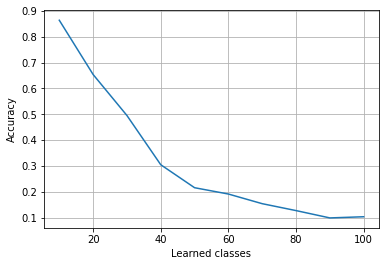

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Learned classes')
plt.plot(np.arange(10, 110, 10), accuracies)
plt.grid(True)
plt.show()

# **Learning without Fortgetting (LwF) model**

**LwF**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader

class LwF(nn.Module):
    def __init__(self, n_classes):
        self.total_num_classes = n_classes
        self.known_classes = 0
        self.list_known_classes=[]
        self.exemplar_sets = []
        self.flag_mean = True
        self.exemplar_means = []

        # We take a standard ResNet and Extend it
        super(LwF, self).__init__()
        self.extractor = resnet32()
        self.fully_connected = nn.Linear(self.extractor.out_dim, 0, bias=True)
        torch.nn.init.xavier_uniform_(self.fully_connected.weight)

        self.fully_connected.bias.data.fill_(0.01)
        self.loss=nn.BCEWithLogitsLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001)
        self.scheduler=MultiStepLR(self.optimizer,[47,63],gamma=GAMMA)
        
    def forward(self, x):
        # X: input data
        self.extractor.to(DEVICE)
        self.fully_connected.to(DEVICE)
        x = self.extractor(x)
        x = self.fully_connected(x)
        return x

    def increment_classes(self, classes_to_add):          # increments the number of classes we are using
      n_classes_to_add = len(classes_to_add)
      self.list_known_classes+=classes_to_add             #add the new classes
      print(f"Known classes {self.list_known_classes}")
      weight = self.fully_connected.weight.data
      feature_size = self.fully_connected.in_features
      old_num_classes = self.fully_connected.out_features
      self.fully_connected = nn.Linear(
          feature_size, old_num_classes+n_classes_to_add, bias = True)
      self.fully_connected.weight.data[:old_num_classes] = weight

    def update_representation(self, dataset):             
        # self.combine_dataset_with_exemplars(dataset)
        # self.flag_mean = True
        classes_to_idx = dataset.labels_to_int
        new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes] #gets indexes of new classes only

        train_data_loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        
        preds_old_net = []
        #preds_old_net = torch.zeros(len(dataset), self.num_classes).cuda()
        
        if self.known_classes > 0:

          self.eval()
          logits_old_net = torch.zeros(len(dataset.data), self.known_classes).cuda()
          with torch.no_grad():
            for indices, images, labels in train_data_loader:
              images = images.to(DEVICE)
              g = self.forward(images)
              sigmoid = torch.nn.Sigmoid()
              logits_old_net[indices] = sigmoid(g)

          torch.cuda.empty_cache()

        self.increment_classes(new_classes)
        
        optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
        scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
        self.train()

        eye = torch.eye(self.known_classes+len(new_classes))

        for epoch in range(NUM_EPOCHS):
          print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
          i=0
          for indices, images, labels in train_data_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            indices = indices.to(DEVICE)
            optimizer.zero_grad()
            output = self.forward(images)

            if self.known_classes==0:
              labels_one_hot_new_classes = []
              for label in labels:
                labels_one_hot_new_classes.append(eye[label])
              labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
              loss=self.loss(output,labels_one_hot_new_classes)
              loss.backward()
            if self.known_classes > 0:
              labels_one_hot_new_classes = eye[:, self.known_classes:]
 
              labels_one_hot = []
              for label in labels:
                labels_one_hot.append(labels_one_hot_new_classes[label])
              labels_one_hot = torch.stack(labels_one_hot).cuda()
              logits = logits_old_net[indices].cuda()
              labels_concatenate=torch.cat((logits,labels_one_hot),dim=1)
              loss=self.loss(output,labels_concatenate)
              loss.backward()
            optimizer.step()
            i+=1
          torch.cuda.empty_cache()
          print(f"Loss: {loss.item()}")
          scheduler.step() 
        self.known_classes += len(new_classes)
    

**Training LwF**

In [ ]:
net = LwF(n_classes=100)
net.to(DEVICE)

for i, train_dataset in enumerate(train_datasets):
  torch.cuda.empty_cache()
  print(f"BATCH [{i}]")
  print(f"Training on {train_dataset.labels} -> {train_dataset.labels_to_int}")
  net.train()
  net.update_representation(copy.deepcopy(train_dataset))

  net.eval()
  corrects = 0
  total = 0
  with torch.no_grad():
    for num in range(i+1):
      print(f"Validating classes {test_datasets[num].labels} -> {test_datasets[num].labels_to_int}")
      test_dataloader = DataLoader(test_datasets[num], batch_size=BATCH_SIZE, num_workers=4, shuffle = True)
      for _, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)
        # Update Corrects
        corrects += torch.sum(preds == labels.data).data.item()
        total += len(images)

    torch.cuda.empty_cache()
    # Calculate Accuracy
    accuracy = corrects / float(total)
    print(f"Accuracy: {accuracy}")

BATCH [0]
Training on ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Epoch [1/70], LR: [2.0]
Loss: 0.33715981245040894
Epoch [2/70], LR: [2.0]
Loss: 0.31833168864250183
Epoch [3/70], LR: [2.0]
Loss: 0.2927075922489166
Epoch [4/70], LR: [2.0]
Loss: 0.26772040128707886
Epoch [5/70], LR: [2.0]
Loss: 0.2996297776699066
Epoch [6/70], LR: [2.0]
Loss: 0.28331801295280457
Epoch [7/70], LR: [2.0]
Loss: 0.34404587745666504
Epoch [8/70], LR: [2.0]
Loss: 0.2553049623966217
Epoch [9/70], LR: [2.0]
Loss: 0.3227398991584778
Epoch [10/70], LR: [2.0]
Loss: 0.2415180653333664
Epoch [11/70], LR: [2.0]
Loss: 0.29381632804870605
Epoch [12/70], LR: [2.0]
Loss: 0.2299620360136032
Epoch [13/70], LR: [2.0]
Loss: 0.28154703974723816
Epoch [14/70], LR: [2.0]
Loss: 0.3108881711959839
Epoch [15/70], LR: [2.0]
Loss: 0.20036859810352325
Epoch [16/70], LR: [2.0]
Loss: 0.20122289657

# **Catastrophic forgetting model (finetuning on iCaRL paper)**

CATASTROPHIC FORGETTING NET



In [ ]:
class CatastrophicForgetting(nn.Module):
    def __init__(self, n_classes):
        self.total_num_classes = n_classes
        self.known_classes = 0
        self.list_known_classes=[]
        self.exemplar_sets = []
        self.flag_mean = True
        self.exemplar_means = []

        # We take a standard ResNet and Extend it
        super(CatastrophicForgetting, self).__init__()
        self.extractor = resnet32()
        self.fully_connected = nn.Linear(self.extractor.out_dim, 0, bias=True)
        torch.nn.init.xavier_uniform_(self.fully_connected.weight)

        self.fully_connected.bias.data.fill_(0.01)
        self.loss=nn.BCEWithLogitsLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001)
        self.scheduler=MultiStepLR(self.optimizer,[47,63],gamma=GAMMA)
        
    def forward(self, x):
        # X: input data
        self.extractor.to(DEVICE)
        self.fully_connected.to(DEVICE)
        x = self.extractor(x)
        x = self.fully_connected(x)
        return x


    def increment_classes(self, classes_to_add):          # increments the number of classes we are using
      n_classes_to_add = len(classes_to_add)
      self.list_known_classes+=classes_to_add             #add the new classes
      print(f"Known classes {self.list_known_classes}")
      weight = self.fully_connected.weight.data
      feature_size = self.fully_connected.in_features
      old_num_classes = self.fully_connected.out_features
      self.fully_connected = nn.Linear(
          feature_size, old_num_classes+n_classes_to_add, bias = True)
      self.fully_connected.weight.data[:old_num_classes] = weight


    def update_representation(self, dataset):             
        classes_to_idx = dataset.labels_to_int
        new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes] #gets indexes of new classes only

        train_data_loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

        self.increment_classes(new_classes)
        
        optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
        scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
        self.train()

        eye = torch.eye(self.known_classes+len(new_classes))

        for epoch in range(NUM_EPOCHS):
          print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
          i=0
          for indices, images, labels in train_data_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            indices = indices.to(DEVICE)
            optimizer.zero_grad()
            output = self.forward(images)
            
            labels_one_hot_new_classes = []
            for label in labels:
              labels_one_hot_new_classes.append(eye[label])
            labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
            loss=self.loss(output,labels_one_hot_new_classes)
            loss.backward()
            optimizer.step()
          torch.cuda.empty_cache()
          print(f"Loss: {loss.item()}")
          scheduler.step() 
        self.known_classes += len(new_classes)


TRAINING CATASTROPHIC FORGETTING

In [ ]:
net = CatastrophicForgetting(n_classes=100)
net.to(DEVICE)

for i, train_dataset in enumerate(train_datasets):
  torch.cuda.empty_cache()
  print(f"BATCH [{i}]")
  print(f"Training on {train_dataset.labels} -> {train_dataset.labels_to_int}")
  net.train()
  net.update_representation(copy.deepcopy(train_dataset))


  net.eval()
  corrects = 0
  total = 0
  with torch.no_grad():
    for num in range(i+1):
      print(f"Validating classes {test_datasets[num].labels} -> {test_datasets[num].labels_to_int}")
      test_dataloader = DataLoader(test_datasets[num], batch_size=BATCH_SIZE, num_workers=4, shuffle = True)
      for _, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)
        corrects += torch.sum(preds == labels.data).data.item()
        total += len(images)
    torch.cuda.empty_cache()
    # Calculate Accuracy
    accuracy = corrects / float(total)
    print(f"Accuracy: {accuracy}")